# 运行的代码
```
python train.py --data_dir=data/example/processed --save_config=checkpoints/example_config.json --save_checkpoint=checkpoints/example_model.pth --save_log=logs/example.log 
--positional_encoding
```

In [1]:
data_dir="data/example/processed"
save_config="checkpoints/example_config.json"
save_checkpoint="checkpoints/example_model.pth"
save_log="logs/example.log"

In [2]:
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader

config=None
#如果不是None，那应该是一个json文件的路径
"""
config={
    
}
实际上要把一下参数改成config的字典，key和value的，但比较懒，就这样了
"""

device='cuda' if torch.cuda.is_available() else 'cpu'

print_every=1
save_every=1

vocabulary_size=None

d_model=128
layers_count=1
heads_count=2
d_ff=128
dropout_prob=0.1

label_smoothing=0.1
optimizer="Adam"
lr=0.001

batch_size=64
epochs=100

dataset_limit=None

positional_encoding=True
#用于指示模型是否使用位置编码（Positional Encoding）。
#默认居然是没有用，不行，我得改成True
#最后跑代码跑起来，确实加上位置编码后好多了
clip_grads=False

#这些输入参数大概就这样，都是比较熟悉的东西
"""
    parser.add_argument('--positional_encoding', action='store_true')
    `action` 参数用于指定解析器对象将在遇到该参数时执行的动作。
    在这个例子中，`action='store_true'` 表示在遇到 `--positional_encoding` 参数时，
    将会把 `positional_encoding` 参数赋值为 `True`。
    这意味着，如果在命令行中指定了 `--positional_encoding`，那么 `args.positional_encoding` 将被设置为 True，
    否则 `args.positional_encoding` 将为 False。
"""

"\n    parser.add_argument('--positional_encoding', action='store_true')\n    `action` 参数用于指定解析器对象将在遇到该参数时执行的动作。\n    在这个例子中，`action='store_true'` 表示在遇到 `--positional_encoding` 参数时，\n    将会把 `positional_encoding` 参数赋值为 `True`。\n    这意味着，如果在命令行中指定了 `--positional_encoding`，那么 `args.positional_encoding` 将被设置为 True，\n    否则 `args.positional_encoding` 将为 False。\n"

In [3]:
#有个**config的表达，算了算了，写一个config吧
config={
    'data_dir':"data/example/processed",
    'save_config':"checkpoints/example_config.json",
    'save_checkpoint':"checkpoints/example_model.pth",
    'save_log':"logs/example.log",
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'print_every': 1,
    'save_every': 1,
    'vocabulary_size': None,
    'd_model': 128,
    'layers_count': 1,
    'heads_count': 2,
    'd_ff': 128,
    'dropout_prob': 0.1,
    'label_smoothing': 0.1,
    'optimizer': "Adam",
    'lr': 0.001,
    'batch_size': 64,
    'epochs': 100,
    'positional_encoding': True,
    'clip_grads': False,
    'dataset_limit':None
}

In [4]:
from utils.log import get_logger
import random
import numpy as np
from datetime import datetime

#要学会写日志系统啊啊啊啊

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)#指定随机的种子

run_name_format = (
    "d_model={d_model}-"
    "layers_count={layers_count}-"
    "heads_count={heads_count}-"
    "pe={positional_encoding}-"
    "optimizer={optimizer}-"
    "{timestamp}"
)
#用于表示输出日志的输出文本格式

run_name = run_name_format.format(**config, timestamp=datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
run_name #按照格式获得str文本输出
logger = get_logger(run_name)
logger.info(f'Run name : {run_name}')#,save_log=config['save_log']
logger.info(config)
#一次info输出一条日志的内容

[INFO] 2023-05-22 13:54:14 > Run name : d_model=128-layers_count=1-heads_count=2-pe=True-optimizer=Adam-2023_05_22_13_54_14
[INFO] 2023-05-22 13:54:14 > {'data_dir': 'data/example/processed', 'save_config': 'checkpoints/example_config.json', 'save_checkpoint': 'checkpoints/example_model.pth', 'save_log': 'logs/example.log', 'device': 'cpu', 'print_every': 1, 'save_every': 1, 'vocabulary_size': None, 'd_model': 128, 'layers_count': 1, 'heads_count': 2, 'd_ff': 128, 'dropout_prob': 0.1, 'label_smoothing': 0.1, 'optimizer': 'Adam', 'lr': 0.001, 'batch_size': 64, 'epochs': 100, 'positional_encoding': True, 'clip_grads': False, 'dataset_limit': None}


# 加载数据，在数据处理中说过了的

In [5]:
PAD_TOKEN = '<PAD>'#变成编码后，应该填充是0
UNK_TOKEN = '<UNK>'#未知是1
START_TOKEN = '<StartSent>'#开始是2
END_TOKEN = '<EndSent>'#结束是3

from os.path import dirname, abspath, join, exists
from collections import Counter
# `Counter` 是一个 Python 内置类，用于统计可迭代对象中元素出现的次数。它返回一个字典，
# 字典的 key 是元素，value 是对应元素出现的次数。

from dictionaries import IndexDictionary

In [6]:
logger.info('构建词汇表字典...')
source_dictionary = IndexDictionary.load(config['data_dir'], mode='source', vocabulary_size=config['vocabulary_size'])
target_dictionary = IndexDictionary.load(config['data_dir'], mode='target', vocabulary_size=config['vocabulary_size'])
logger.info(f'英文词汇表总计 : {source_dictionary.vocabulary_size} 词')#日志
logger.info(f'德文词汇表总计 : {target_dictionary.vocabulary_size} 词')#日志

[INFO] 2023-05-22 13:54:14 > 构建词汇表字典...
[INFO] 2023-05-22 13:54:14 > 英文词汇表总计 : 24995 词
[INFO] 2023-05-22 13:54:14 > 德文词汇表总计 : 35820 词


In [7]:
from datasets import IndexedInputTargetTranslationDataset

PAD_INDEX = 0

def input_target_collate_fn(batch):
    #这段代码 `input_target_collate_fn` 实现的是一个batch的padding（填充）以及转换为tensor的操作。
    #输入是由多个sample组成的batch，其中每个sample由sources（编码器输入）、inputs（解码器输入）和
    #targets（解码器输出）三个部分组成。
    """merges a list of samples to form a mini-batch."""

    # indexed_sources = [sources for sources, inputs, targets in batch]
    # indexed_inputs = [inputs for sources, inputs, targets in batch]
    # indexed_targets = [targets for sources, inputs, targets in batch]

    sources_lengths = [len(sources) for sources, inputs, targets in batch]
    inputs_lengths = [len(inputs) for sources, inputs, targets in batch]
    targets_lengths = [len(targets) for sources, inputs, targets in batch]

    sources_max_length = max(sources_lengths)#获取数据集里面的三部分的最大长度
    inputs_max_length = max(inputs_lengths)
    targets_max_length = max(targets_lengths)

    sources_padded = [sources + [PAD_INDEX] * (sources_max_length - len(sources)) for sources, inputs, targets in batch]
    #用长度差值填充，统一都填充为训练数据集里面长度最长的
    inputs_padded = [inputs + [PAD_INDEX] * (inputs_max_length - len(inputs)) for sources, inputs, targets in batch]
    targets_padded = [targets + [PAD_INDEX] * (targets_max_length - len(targets)) for sources, inputs, targets in batch]

    sources_tensor = torch.tensor(sources_padded)#数据类型转换，转为torch
    inputs_tensor = torch.tensor(inputs_padded)
    targets_tensor = torch.tensor(targets_padded)

    # lengths = {
    #     'sources_lengths': torch.tensor(sources_lengths),
    #     'inputs_lengths': torch.tensor(inputs_lengths),
    #     'targets_lengths': torch.tensor(targets_lengths)
    # }

    return sources_tensor, inputs_tensor, targets_tensor

In [8]:
train_dataset = IndexedInputTargetTranslationDataset(
    data_dir=config['data_dir'],
    phase='train',
    vocabulary_size=config['vocabulary_size'],
    limit=config['dataset_limit'])

val_dataset = IndexedInputTargetTranslationDataset(
    data_dir=config['data_dir'],
    phase='val',
    vocabulary_size=config['vocabulary_size'],
    limit=config['dataset_limit'])

train_dataloader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
#     shuffle=True, #研究怎么算的时候，就简单点，不随机了，而且还只取一小块来算
    shuffle=False,
    collate_fn=input_target_collate_fn)
#DataLoader的collate_fn函数是来实现序列padding的操作。#输入是batch，输出是batch中的tensor数据

val_dataloader = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    collate_fn=input_target_collate_fn)

In [9]:
train_dataset.data[0][0]#英语

[805,
 59,
 60,
 7624,
 38,
 8,
 21,
 56,
 1814,
 5,
 56,
 63,
 1,
 8,
 396,
 268,
 5497,
 1,
 116,
 89,
 223,
 9547,
 13,
 1,
 93,
 577,
 5,
 2978,
 423,
 1617,
 1920,
 8,
 6173,
 13,
 2409,
 180,
 60,
 4686,
 1377,
 101,
 4064,
 29]

In [10]:
import itertools

n_items = 1  # 希望只取第一项
batch_iter = iter(train_dataloader)
for i, batch in itertools.islice(enumerate(batch_iter), n_items):
    data_ba1=batch
    print(batch)

(tensor([[  805,    59,    60,  ...,     0,     0,     0],
        [ 5136, 21225,    26,  ...,    10,    11,    29],
        [   30,    31,    32,  ...,     0,     0,     0],
        ...,
        [  726,   727,   728,  ...,     0,     0,     0],
        [  735,     8,    79,  ...,     0,     0,     0],
        [  569,   110,     8,  ...,    29,     0,     0]]), tensor([[  2,   4,   5,  ...,   0,   0,   0],
        [  2,  33,  15,  ...,   0,   0,   0],
        [  2,  56,  57,  ...,   0,   0,   0],
        ...,
        [  2, 759,  22,  ...,   0,   0,   0],
        [  2, 767, 107,  ...,   0,   0,   0],
        [  2,  32, 774,  ...,   0,   0,   0]]), tensor([[  4,   5,   6,  ...,   0,   0,   0],
        [ 33,  15,  34,  ...,   0,   0,   0],
        [ 56,  57,  58,  ...,   0,   0,   0],
        ...,
        [759,  22, 760,  ...,   0,   0,   0],
        [767, 107, 733,  ...,   0,   0,   0],
        [ 32, 774,  64,  ...,   0,   0,   0]]))


In [11]:
print(data_ba1[0].shape,data_ba1[1].shape,data_ba1[2].shape)
data_ba1[0]

torch.Size([64, 46]) torch.Size([64, 49]) torch.Size([64, 49])


tensor([[  805,    59,    60,  ...,     0,     0,     0],
        [ 5136, 21225,    26,  ...,    10,    11,    29],
        [   30,    31,    32,  ...,     0,     0,     0],
        ...,
        [  726,   727,   728,  ...,     0,     0,     0],
        [  735,     8,    79,  ...,     0,     0,     0],
        [  569,   110,     8,  ...,    29,     0,     0]])

In [12]:
data_ba1[0][0]#可以看到填充

tensor([ 805,   59,   60, 7624,   38,    8,   21,   56, 1814,    5,   56,   63,
           1,    8,  396,  268, 5497,    1,  116,   89,  223, 9547,   13,    1,
          93,  577,    5, 2978,  423, 1617, 1920,    8, 6173,   13, 2409,  180,
          60, 4686, 1377,  101, 4064,   29,    0,    0,    0,    0])

In [13]:
data_ba1[0][0]

tensor([ 805,   59,   60, 7624,   38,    8,   21,   56, 1814,    5,   56,   63,
           1,    8,  396,  268, 5497,    1,  116,   89,  223, 9547,   13,    1,
          93,  577,    5, 2978,  423, 1617, 1920,    8, 6173,   13, 2409,  180,
          60, 4686, 1377,  101, 4064,   29,    0,    0,    0,    0])

# 到了精彩刺激的位置编码部分
原来位置编码是属于嵌入层embedding的内容，这块是一直没理解完全的东西

位置编码是通过对正弦和余弦函数的组合进行计算得到的，其形式为$PE(pos,2i) = sin(\frac{pos}{10000^{2i/d_{model}}})$和$PE(pos,2i+1) = cos(\frac{pos}{10000^{2i/d_{model}}})$，其中$pos$为序列中位置的下标，$i$为位置编码中的维度，$d_{model}$为模型中词嵌入的维度。我们将位置编码与原始的词向量相加，来增加序列位置信息的表示能力。

`n_position` 控制序列最大长度，通常设置为训练数据中最大序列长度的两倍。

`get_position_angle_vec` 函数用于生成每个输入位置的位置编码张量。输入的参数 `position` 是相对于当前词汇的位置（从0开始），将根据此位置计算位置编码张量的每一维。具体而言，该函数生成一个长度为 `d_hid` 的张量，其中第$i$维的值由以下公式给出：

$$\text{pos}(position, i) = \begin{cases}
sin\left(\frac{position}{10000^{2i/d_{hid}}}\right) & i \text{ is even}\\
cos\left(\frac{position}{10000^{2(i-1)/d_{hid}}}\right) & i \text{ is odd}
\end{cases}$$

其中，$d_{hid}$ 是位置编码的隐藏维度，$i$ 是维度编号，$position$ 是当前输入位置。

In [14]:
# 吐槽下，感觉inumpy里面没有vscode的md渲染的好看
import torch
from torch import nn
import math

# 嘶，位置嵌入，包含了一个nn.Embedding嵌入层参数
class PositionalEncoding(nn.Module):
    """
    Implements the sinusoidal positional encoding for
    non-recurrent neural networks.

    Implementation based on "Attention Is All You Need"
    :cite:`DBLP:journals/corr/VaswaniSPUJGKP17`

    Args:
       dropout_prob (float): dropout parameter
       dim (int): embedding size
    """

    def __init__(self, num_embeddings, embedding_dim, dim, dropout_prob=0., padding_idx=0, max_len=5000):
        super(PositionalEncoding, self).__init__()
        """
        - `num_embeddings`：单词表中单词的数量。
        - `embedding_dim`：单词嵌入的维数或特征数量。
        - `dim`：位置编码矩阵的维度，即 `(max_len, dim)`。
        - `dropout_prob`：可选的 Dropout 的概率，默认为 0。
        - `padding_idx`：填充符的索引，默认为 0。
        - `max_len`：输入句子中的单词数量的最大值。超过最大值的单词将被截短。看上去只是个安全的词吧，因为一个句子内单词数量超过5k感觉有点太大了
        """
        pe = torch.zeros(max_len, dim) # 句子中的最大单词数量，dim值设定为128，与期望的表示含义的嵌入层字典的维度是一样的
        position = torch.arange(0, max_len).unsqueeze(1) # torch.Size([5000, 1])
        div_term = torch.exp((torch.arange(0, dim, 2) *
                             -(math.log(10000.0) / dim)).float()) # torch.Size([64])
        pe[:, 0::2] = torch.sin(position.float() * div_term)#偶数走sin
        pe[:, 1::2] = torch.cos(position.float() * div_term)#奇数走cos
        pe = pe.unsqueeze(0)#在第一个位置增加一个维度,暂时没理解为什么。哦，是为了方便后边相加

        self.num_embeddings = num_embeddings #2w多
        self.embedding_dim = embedding_dim #128
        self.embbedding = nn.Embedding(num_embeddings, embedding_dim, padding_idx=padding_idx)
        #进来的是（64，46），出去的是（64,46，128）,语义的嵌入层
        # num_embeddings - 词嵌入字典大小，即一个字典里要有多少个词。这里有24995个词
        # embedding_dim - 每个词嵌入向量的大小。
        self.weight = self.embbedding.weight#2w多词的大字典
        self.register_buffer('pe', pe)#注册表的写法，但我还不太理解这种注册表的写法
        self.dropout = nn.Dropout(p=dropout_prob)
        self.dim = dim

    def forward(self, x, step=None):
        x = self.embbedding(x)#嵌入层
        x = x * math.sqrt(self.dim)#128的根号，差不多11.多
        if step is None:
            x = x + self.pe[:, :x.size(1)]#一开始就是这个，也是一种字典的映射
        else:
            x = x + self.pe[:, step]
        x = self.dropout(x)
        return x
    # 输入一个 one-hot 编码的向量，输出一个指定大小的嵌入向量，大小为 (num_embeddings, embedding_dim)，
    # 其中 num_embeddings 表示单词表中单词的数量，embedding_dim 表示嵌入向量的维度。

# 先来整理一下embedding嵌入层的思想

In [15]:
source_dictionary.vocabulary_size

24995

In [16]:
source_embedding = PositionalEncoding(
    num_embeddings=source_dictionary.vocabulary_size,#进入的就是词汇表的最大词汇量
    embedding_dim=config['d_model'],#128
    dim=config['d_model']#还是128
)

In [17]:
data_ba1[0].shape

torch.Size([64, 46])

In [18]:
source_embedding(data_ba1[0]).shape

torch.Size([64, 46, 128])

In [19]:
source_embedding.embbedding(data_ba1[0]).shape

torch.Size([64, 46, 128])

哦，我理解了。embedding层就是为词汇表字典里面的每个词,张出一个矩阵来。
也就是如果是一个24995词的词汇表，我设定学习的特征为128个。就相当于建立了一个24995*128的矩阵。让模型去自己建立这些词中的关联，为这24995个词语，在一个高纬度，找到词语之间的特征。就相当于一维的数据映射到二维去，然后一维的数据都是自然语言中的词语，离散的，数据与数据中没有任何关联。这就好像我可以用一种编码，假定“你”为数字1，“好”为数字2。
这样可以把文字编码为算法可以处理的数字。一句话可以变为
```
[ 805,   59,   60, 7624,   38,    8,   21,   56, 1814,    5,   56,   63,
   1,    8,  396,  268, 5497,    1,  116,   89,  223, 9547,   13,    1,
  93,  577,    5, 2978,  423, 1617, 1920,    8, 6173,   13, 2409,  180,
  60, 4686, 1377,  101, 4064,   29,    0,    0,    0,    0]
```
这样子，就代表一句话。但这样的句子中，数字除了表现这个文字之外没有任何意义。也就是如果我就这样给模型去预测，即使最后模型预测出来一个位置的数字是1.32。也无法映射到一个文字上，因为1.32既不是1也不是2。而且和1：“你”以及2：“好”，没有任何的关系，这样的模型没有任何意义。
但是升维就不一样了，把1张成一个（128，1）维度的矩阵。这样矩阵里面的数字就有意义了，模型最后预测出来会得到这样的128维度的一个向量。然后我在这个（24995，128）大小的字典里面，去计算和模型预测出来的结果，即128维度的一个向量，几何距离最近的一个点。
那么这个点对应的那个数字编码，就是模型预测出来的文字了。
原来这就是模型进行文字处理的过程么？!

In [20]:
print(source_embedding.embbedding.weight.shape)
source_embedding.embbedding.weight
#没有经过训练的初始的随机权重，只是用来演示一下下这个意思，单词会有原来的一维的数据，张成128维的数据

torch.Size([24995, 128])


Parameter containing:
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-8.0483e-01,  5.6561e-01,  6.1036e-01,  ...,  3.9040e-01,
          3.3064e-02, -1.0234e+00],
        [-4.9554e-01, -3.6151e-01,  5.8511e-01,  ..., -2.3447e-01,
         -1.8972e+00, -2.2274e-03],
        ...,
        [-1.6313e-02,  1.8380e-01, -4.9615e-01,  ...,  7.0171e-01,
          1.1316e+00, -8.3117e-02],
        [ 4.3484e-01, -5.1530e-01, -7.9931e-01,  ...,  2.6275e+00,
         -2.5973e-01, -1.1176e+00],
        [-3.6312e-02, -2.7601e-01,  2.4469e-01,  ...,  9.8803e-01,
          5.2695e-01,  1.4960e+00]], requires_grad=True)

这么看来，每次运行embbedding，都会按照input中的编码，作为索引，重新构建一个权重矩阵，比如说我的batch输入是[64, 46]的矩阵。embbedding层会从词汇表字典([24995, 128])中，按照batch中每个单词为字典的索引，找到单词对应的那一个128维的向量（数字几就是第几行的那一个行向量），然后重新构建出一个[64,46,128]大小的矩阵，作为真正模型的矩阵输入。证明如下：

In [21]:
data_ba1[0][0][0]# 805是一个词的one-hot编码

tensor(805)

In [22]:
source_embedding.embbedding(data_ba1[0][0][0])#对这一个编码做一次嵌入运算

tensor([ 1.2183, -2.4295,  0.6857, -0.4307,  0.9181,  1.6220, -0.0054, -0.5213,
        -1.3888, -0.2537, -0.5412,  0.1043,  1.5984,  0.0255, -0.7737,  0.2953,
         1.2508,  0.4276, -0.6108, -1.2184,  0.0681, -0.5525,  0.9137,  0.8971,
         1.4898,  1.2031, -0.4374, -0.6724, -0.9513, -0.1241,  2.9146, -0.0321,
         0.5172, -0.1061,  0.9081, -1.4896,  2.3769,  0.7310,  0.3020, -0.3194,
        -0.0848,  0.9462, -0.8619, -2.2512,  0.5916,  2.1409, -2.0100,  1.1760,
        -0.2115,  1.8327, -1.8359, -0.0948, -0.4379,  1.1861,  0.5508, -0.4279,
         0.2458, -0.7354, -0.1472,  2.0182,  0.6311,  0.2104,  0.5968,  0.1889,
         1.1959,  0.5068, -0.4665,  1.2088, -2.0923,  0.5582,  1.7240, -0.8665,
         0.8535, -1.1486, -0.0932,  0.4250, -0.3493,  0.8337,  0.6114, -0.8077,
        -0.8249, -0.4853, -3.2131,  1.6970,  0.2435,  0.4647, -0.5086,  1.0435,
         0.5200,  0.5291,  0.1265, -0.5428, -0.4029, -0.2562, -2.1545,  0.1444,
        -0.1124,  0.3971, -0.4647,  1.22

In [23]:
#可以看到，二者是等效的
source_embedding.embbedding.weight[data_ba1[0][0][0]]# 对应那一行的权重

tensor([ 1.2183, -2.4295,  0.6857, -0.4307,  0.9181,  1.6220, -0.0054, -0.5213,
        -1.3888, -0.2537, -0.5412,  0.1043,  1.5984,  0.0255, -0.7737,  0.2953,
         1.2508,  0.4276, -0.6108, -1.2184,  0.0681, -0.5525,  0.9137,  0.8971,
         1.4898,  1.2031, -0.4374, -0.6724, -0.9513, -0.1241,  2.9146, -0.0321,
         0.5172, -0.1061,  0.9081, -1.4896,  2.3769,  0.7310,  0.3020, -0.3194,
        -0.0848,  0.9462, -0.8619, -2.2512,  0.5916,  2.1409, -2.0100,  1.1760,
        -0.2115,  1.8327, -1.8359, -0.0948, -0.4379,  1.1861,  0.5508, -0.4279,
         0.2458, -0.7354, -0.1472,  2.0182,  0.6311,  0.2104,  0.5968,  0.1889,
         1.1959,  0.5068, -0.4665,  1.2088, -2.0923,  0.5582,  1.7240, -0.8665,
         0.8535, -1.1486, -0.0932,  0.4250, -0.3493,  0.8337,  0.6114, -0.8077,
        -0.8249, -0.4853, -3.2131,  1.6970,  0.2435,  0.4647, -0.5086,  1.0435,
         0.5200,  0.5291,  0.1265, -0.5428, -0.4029, -0.2562, -2.1545,  0.1444,
        -0.1124,  0.3971, -0.4647,  1.22

## 啧，想到啥写啥，这块理解后反而不知道应该怎么解释了。

之前一直在疑惑的是，嵌入层是如何反向传播的，因为原本，比如说机器学习啥的，一直处理的数据的反向传播，都是对权重进行的。例如线性回归，假设我的模型为
$$y=wx+b$$
,损失函数为
$$L=(text{y}_pre-text{y}_real)^2$$
那么我反向传播的时候，计算的偏导数都只是对w和b计算，从来没有对x计算的。而NLP模型实际上的数据输入，并不是ont-hot编码后的每次都不会改变的“原始”数据，而是嵌入层的数据作为输入。所以我们如果类比一下线性模型和嵌入层，就会有种奇怪的理解，这里的嵌入层的大字典其实就是线性回归里面的输入X。也就是在这里的反向传播中，我们会对输入X求偏导数，这个损失函数是对于W、B还有X的，这看起来很奇怪，但再深入思考后，就能理解了。

从偏导数的角度来讲，我们每次计算的时候，其实就是把其他变量当成常数，然后只有需要求偏导的变量是一个变量，然后求导就行了。那么，这样看，对于损失函数来讲，其实w,b,x都没什么区别，都是一个互相独立的变量，也就是，我们也可以让损失函数对模型的自变量X求偏导，然后对X进行梯度下降。去获得一个让模型的总体损失更小的自变量X的值。这样子从数学的角度来看是可行的(，因为模型的结构是固定的，求偏导都能求，而且每次计算的参数w,x,b都是一个确定的数字，损失也是可以求的一个数)。只不过这样的行为，对于一种线性回归来讲，没什么用。因为我用梯度下降求出来的线性回归的一个优化后的float的x，固然可以使得我原有的X输入进来后，计算出来的整体损失会比之前小，但对于一开始，我们所接触的线性回归而言，这样的优化后的x没有意义，因为我们的输入都是固定的。比如我用鸢尾花数据集来训练，有一个花瓣长度x为1.2，模型对x进行优化后，得出，x为1.2的时候，应该x变为1.0能让整体的损失更小。（具体的数据忘了2333，也懒得查了）但这个是没有意义的，因为下次计算的时候，x的值还是1.2，实际的花瓣不会因为要让损失更小而变成1.0，或者说，当x变为1.0的时候，这朵花也变为另一朵花了，也不是原来的1.2的那一朵了。

但类比到NLP的数据的特点，就会发现，这样的处理方法非常的合适，因为这样可以优化出让模型总体损失更小的x。而我实际的数据是字典的索引值，优化完后，下一次模型的数据，就会由于字典的索引关系不会改变，而是优化后的输入数据。也就是我这样优化，会让我每次的训练的输入数据都不一样，但都会朝着让总体损失越来越小的目标走去。

总结起来看，这样的嵌入层，就是一种离散数据连续化的方法，数据在一个维度内离散，那么就可以用嵌入层的思想，去映射到更高的维度去，让模型自己在更高的维度的几何空间内，找到连续（浮点数）的关系。而我们的线性回归，由于原始数据已经是连续的了，不需要在连续化了，而且也无法用嵌入层的思想去映射到更高的维度（，因为连续的数据有无穷个，无法穷尽）。

嵌入层主要为了去找到离散数据之间的关联性，连续的数据自己之间，已经存在这种关联了，这是离散数据和连续数据的本质的区别，理解了这个，也就对数据科学本身有了更多的了解。

# 到位置信息的嵌入层了，这回真的是位置信息的嵌入了

$$PE(pos,2i) = sin(\frac{pos}{10000^{2i/d_{model}}})$$

$$PE(pos,2i+1) = cos(\frac{pos}{10000^{2i/d_{model}}})$$

或者写作

$$\text{pos}(position, i) = \begin{cases}
sin\left(\frac{position}{10000^{2i/d_{hid}}}\right) & i \text{ is even}\\
cos\left(\frac{position}{10000^{2(i-1)/d_{hid}}}\right) & i \text{ is odd}
\end{cases}$$

手动步进一下，以方便理解这块的代码

In [24]:
# 先从PE矩阵开始入手，理解这个位置编码的嵌入层字典（？）
dim=128
torch.exp((torch.arange(0, dim, 2) *
          -(math.log(10000.0) / dim)).float()).shape #这是div_term

torch.Size([64])

In [25]:
torch.arange(0, 5000).unsqueeze(1).shape#这是position

torch.Size([5000, 1])

In [26]:
a=torch.exp((torch.arange(0, dim, 2) *
             -(math.log(10000.0) / dim)).float())

In [27]:
# 完全不明白做成这个样子是要干什么
b=torch.arange(0, 5000).unsqueeze(1)
c=a*b
c.shape #这是进入sin或者cos计算之前的数据样子，64维度的，最后的128是错位插值插出来的

torch.Size([5000, 64])

In [28]:
c

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 8.6596e-01, 7.4989e-01,  ..., 1.5399e-04, 1.3335e-04,
         1.1548e-04],
        [2.0000e+00, 1.7319e+00, 1.4998e+00,  ..., 3.0799e-04, 2.6670e-04,
         2.3096e-04],
        ...,
        [4.9970e+03, 4.3272e+03, 3.7472e+03,  ..., 7.6950e-01, 6.6636e-01,
         5.7704e-01],
        [4.9980e+03, 4.3281e+03, 3.7480e+03,  ..., 7.6966e-01, 6.6649e-01,
         5.7716e-01],
        [4.9990e+03, 4.3290e+03, 3.7487e+03,  ..., 7.6981e-01, 6.6663e-01,
         5.7728e-01]])

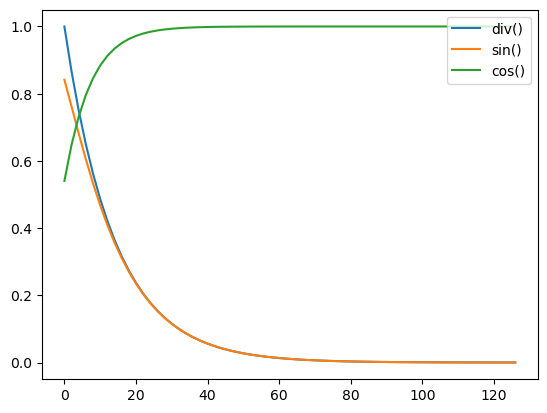

In [29]:
#怪，还是不太理解，画画图来看看数据是什么样的

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


import matplotlib.pyplot as plt
import torch
import math

x = torch.arange(0, 128,2)

dim = 128
div_term = torch.exp((torch.arange(0, dim, 2) * - (math.log(10000.0) / dim)).float())
plt.plot(x, div_term, label='div()')

plt.plot(x, torch.sin(1 * div_term), label='sin()')#数据的索引为1的行
plt.plot(x, torch.cos(1 * div_term), label='cos()')
plt.legend(loc='upper right')
plt.show()

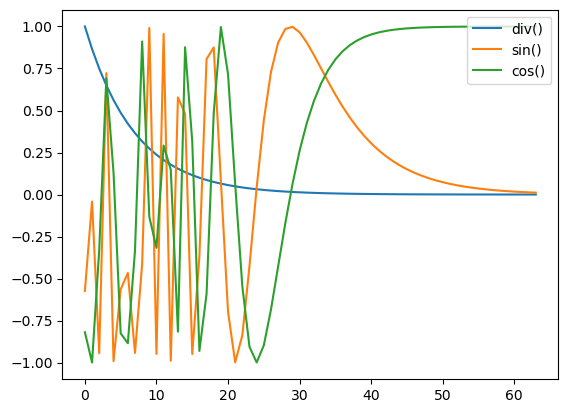

In [30]:
#绘制个动图来理解理解
import numpy as np
from IPython import display

# # 动态展示16张图片
x = torch.arange(0, 64)
dim = 128
div_term = torch.exp((torch.arange(0, dim, 2) * - (math.log(10000.0) / dim)).float())

for i in range(0,100,2):
    plt.plot(x, div_term, label='div()')
    plt.plot(x, torch.sin(i * div_term), label='sin()')#一列列地往下看，一张图是（5000，64）中的一列
    plt.plot(x, torch.cos(i * div_term), label='cos()')#数据的索引为i的行
    plt.legend(loc='upper right')
#     y = np.sin(x + i*np.pi/5)
#     plt.plot(x, y, 'r-')
    display.clear_output(wait=True) # wait=True表示如果要更新cell的内容需要等待下一个输入到cell里边
    plt.show() # 这一步不能省

#有点意思，但没看太懂2333

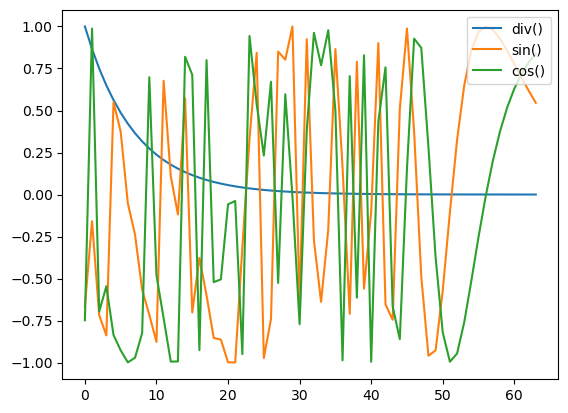

In [31]:
div_term = torch.exp((torch.arange(0, dim, 2) * - (math.log(10000.0) / dim)).float())
plt.plot(x, div_term, label='div()')

plt.plot(x, torch.sin(4999 * div_term), label='sin()')#最后一行的数据
plt.plot(x, torch.cos(4999 * div_term), label='cos()')
plt.legend(loc='upper right')
plt.show()

In [32]:
#所以最后错个位插个值，就是PE矩阵了
max_len=5000
dim=128

pe = torch.zeros(max_len, dim) # 句子中的最大单词数量，dim值设定为128，与期望的表示含义的嵌入层字典的维度是一样的
position = torch.arange(0, max_len).unsqueeze(1) # torch.Size([5000, 1])
div_term = torch.exp((torch.arange(0, dim, 2) *
                     -(math.log(10000.0) / dim)).float()) # torch.Size([64])
pe[:, 0::2] = torch.sin(position.float() * div_term)#偶数走sin
pe[:, 1::2] = torch.cos(position.float() * div_term)#奇数走cos
pe = pe.unsqueeze(0)
pe.shape

torch.Size([1, 5000, 128])

In [33]:
pe[0].shape

torch.Size([5000, 128])

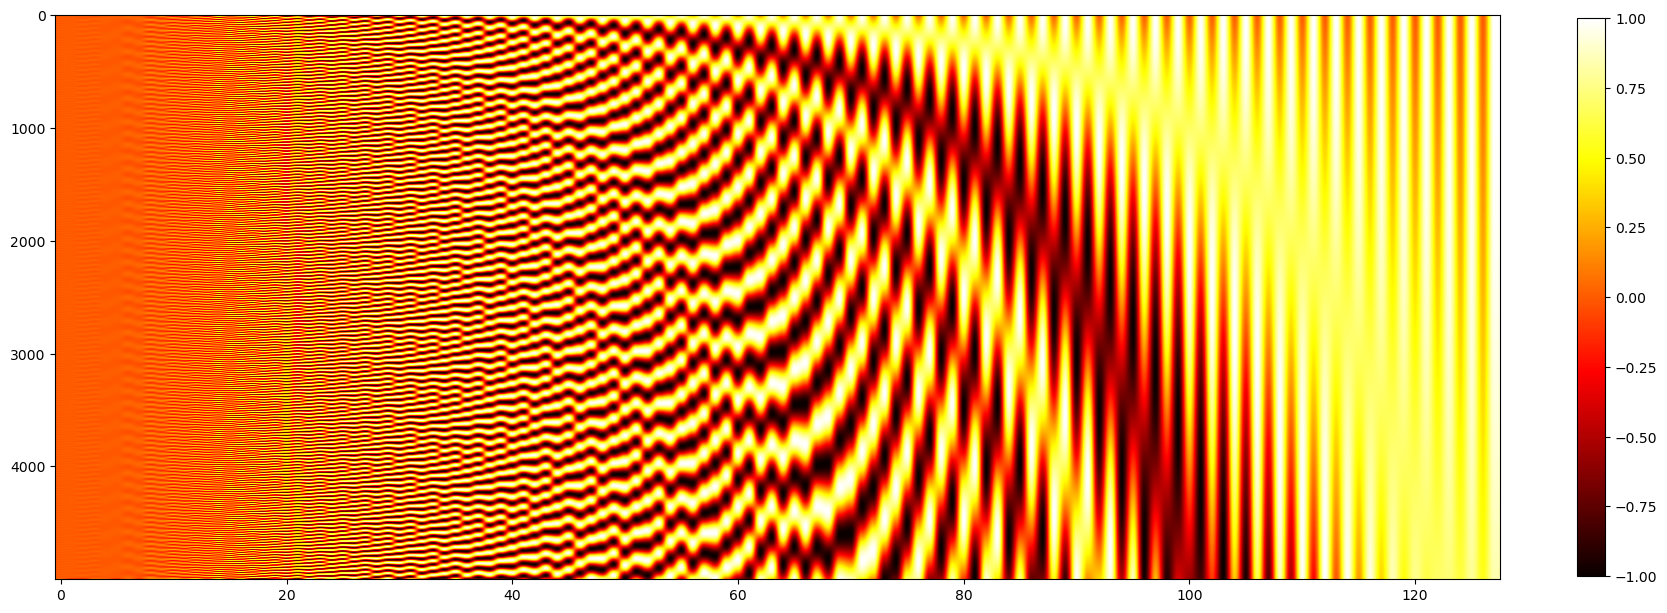

In [34]:
# 有大致概念了，这PE是固定的一个（5k,128）的矩阵

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

fig, ax = plt.subplots(figsize=(20,10))

im=ax.imshow(pe[0], cmap='hot',  aspect=0.01)
plt.colorbar(im,ax=ax, fraction=0.018)
plt.show()
#懂了，这就是这张图片了，原来这张图片就是PE矩阵本身，结合一下之前的动图，就能有点概念了

#大概理解了，结合了一下这个位置编码的作用，只是为了找一个不会重复的向量，以代表每个位置的影响。
#这不是可学习的关系矩阵，只是一个用以表达的固定的关系矩阵

In [35]:
# 要理解forward了，具体再结合pe的使用，来试着理解下是怎么发挥作用的

x=source_embedding(data_ba1[0])#再回到这里
print(x.shape)
print(x.size(1))
print(pe.shape)

torch.Size([64, 46, 128])
46
torch.Size([1, 5000, 128])


In [36]:
print(pe[:,:46].shape)#原来取数的结果是这样的,这样是按照索引为1的维度取
print(pe[0][:46].shape)# 对比一下这个就明白了，索引原来还能这样用，233333
# 但我这建立了5000多行的，只用到了填充后的句的行。可能是随着运行，step就不是None，就会用到其他的内容了，但那样x的形状也变了，怪

torch.Size([1, 46, 128])
torch.Size([46, 128])


In [37]:
x.shape

torch.Size([64, 46, 128])

In [38]:
x[0].shape

torch.Size([46, 128])

In [39]:
pe[:,:46][0].shape

torch.Size([46, 128])

In [40]:
x[0][0]

tensor([ 13.7835, -26.4863,   7.7574,  -3.8728,  10.3866,  19.3512,  -0.0612,
         -4.8977, -15.7129,  -1.8702,  -6.1230,   2.1796,  18.0844,   1.2885,
         -8.7532,   4.3411,  14.1516,   5.8378,  -6.9099, -12.7850,   0.7707,
         -5.2510,  10.3370,  11.1498,  16.8554,  14.6113,  -4.9486,  -6.6072,
        -10.7624,  -0.4044,  32.9747,   0.6368,   5.8518,  -0.2004,  10.2743,
        -15.8526,  26.8914,   9.2703,   3.4171,  -2.6135,  -0.9592,  11.7053,
         -9.7512, -24.4697,   6.6934,  25.2219, -22.7401,  14.3050,  -2.3932,
         21.7341, -20.7713,  -0.0726,  -4.9542,  14.4195,   6.2313,  -3.8410,
          2.7810,  -7.3204,  -1.6657,  23.8337,   7.1405,   3.3809,   6.7524,
          3.1371,  13.5300,   6.7335,  -5.2783,  14.6765, -23.6716,   7.3157,
         19.5050,  -8.8030,   9.6561, -11.9950,  -1.0540,   5.8084,  -3.9513,
         10.4323,   6.9174,  -8.1380,  -9.3321,  -4.4908, -36.3522,  20.1996,
          2.7545,   6.2577,  -5.7545,  12.8056,   5.8827,   6.98

In [41]:
pe[:,:46][0][0]

tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1.])

In [42]:
(x+pe[:,:46])[0][0]

tensor([ 13.7835, -25.4863,   7.7574,  -2.8728,  10.3866,  20.3512,  -0.0612,
         -3.8977, -15.7129,  -0.8702,  -6.1230,   3.1796,  18.0844,   2.2885,
         -8.7532,   5.3411,  14.1516,   6.8378,  -6.9099, -11.7850,   0.7707,
         -4.2510,  10.3370,  12.1498,  16.8554,  15.6113,  -4.9486,  -5.6072,
        -10.7624,   0.5956,  32.9747,   1.6368,   5.8518,   0.7996,  10.2743,
        -14.8526,  26.8914,  10.2703,   3.4171,  -1.6135,  -0.9592,  12.7053,
         -9.7512, -23.4697,   6.6934,  26.2219, -22.7401,  15.3050,  -2.3932,
         22.7341, -20.7713,   0.9274,  -4.9542,  15.4195,   6.2313,  -2.8410,
          2.7810,  -6.3204,  -1.6657,  24.8337,   7.1405,   4.3809,   6.7524,
          4.1371,  13.5300,   7.7335,  -5.2783,  15.6765, -23.6716,   8.3157,
         19.5050,  -7.8030,   9.6561, -10.9950,  -1.0540,   6.8084,  -3.9513,
         11.4323,   6.9174,  -7.1380,  -9.3321,  -3.4908, -36.3522,  21.1996,
          2.7545,   7.2577,  -5.7545,  13.8056,   5.8827,   7.98

In [43]:
pe[:,:46][0][1]

tensor([8.4147e-01, 5.4030e-01, 7.6172e-01, 6.4791e-01, 6.8156e-01, 7.3176e-01,
        6.0469e-01, 7.9646e-01, 5.3317e-01, 8.4601e-01, 4.6795e-01, 8.8376e-01,
        4.0931e-01, 9.1240e-01, 3.5711e-01, 9.3406e-01, 3.1098e-01, 9.5042e-01,
        2.7043e-01, 9.6274e-01, 2.3492e-01, 9.7201e-01, 2.0391e-01, 9.7899e-01,
        1.7689e-01, 9.8423e-01, 1.5338e-01, 9.8817e-01, 1.3296e-01, 9.9112e-01,
        1.1522e-01, 9.9334e-01, 9.9833e-02, 9.9500e-01, 8.6488e-02, 9.9625e-01,
        7.4919e-02, 9.9719e-01, 6.4893e-02, 9.9789e-01, 5.6204e-02, 9.9842e-01,
        4.8678e-02, 9.9881e-01, 4.2157e-02, 9.9911e-01, 3.6509e-02, 9.9933e-01,
        3.1618e-02, 9.9950e-01, 2.7381e-02, 9.9963e-01, 2.3712e-02, 9.9972e-01,
        2.0534e-02, 9.9979e-01, 1.7782e-02, 9.9984e-01, 1.5399e-02, 9.9988e-01,
        1.3335e-02, 9.9991e-01, 1.1548e-02, 9.9993e-01, 9.9998e-03, 9.9995e-01,
        8.6595e-03, 9.9996e-01, 7.4989e-03, 9.9997e-01, 6.4938e-03, 9.9998e-01,
        5.6234e-03, 9.9998e-01, 4.8697e-

In [44]:
x[0][1]

tensor([-14.2724,  -1.7242,   1.5953,  -0.6975,   2.4647,   9.6110,  -1.7890,
        -11.3372,  -4.8355, -10.5727,  31.0179,  24.6295,   8.3505,  18.6853,
         11.2585, -10.4629,   0.4922, -14.2347, -22.0261,  20.5491,  20.8280,
        -14.8780,  10.0087,  -0.2689,  16.3994,   0.1839,  -5.2599,  13.6256,
        -13.0766,  14.2403,  -8.7906, -14.8508,   5.9546,  -5.5969,   4.7809,
          8.6716,   4.1011,  12.9284,   7.9219,   7.0421,  -5.6100,  15.9245,
          7.9193,   5.0077, -16.0514, -13.3877,  -0.1780,   7.0130, -14.0563,
        -12.7460,  14.3141,   6.8433,   1.6330,  -0.6424,   6.2625,  10.0926,
         -3.3995,   7.6239,   0.0728, -13.1785,   2.7270,  -0.5173,   7.0604,
         -9.9299, -20.0375,  -0.5361, -16.0468,  -5.3043,   0.2912,  -2.2495,
          3.9745,   5.0384, -13.9193,   9.2135,  20.4827,  -7.3834,   1.8917,
        -10.3355,   4.2151, -13.8667,  -6.0704,   3.3762,  -0.8548,   9.2545,
          5.0213,   1.8824,   1.4175,  -1.9183,   6.3988,  -3.05

In [45]:
(x+pe[:,:46])[0][1]

tensor([-13.4309,  -1.1839,   2.3570,  -0.0496,   3.1463,  10.3428,  -1.1843,
        -10.5408,  -4.3023,  -9.7267,  31.4859,  25.5133,   8.7598,  19.5977,
         11.6156,  -9.5289,   0.8032, -13.2843, -21.7557,  21.5118,  21.0629,
        -13.9060,  10.2126,   0.7101,  16.5763,   1.1681,  -5.1065,  14.6138,
        -12.9436,  15.2315,  -8.6754, -13.8575,   6.0544,  -4.6019,   4.8674,
          9.6679,   4.1760,  13.9256,   7.9868,   8.0400,  -5.5538,  16.9230,
          7.9680,   6.0065, -16.0092, -12.3886,  -0.1414,   8.0123, -14.0247,
        -11.7465,  14.3415,   7.8429,   1.6567,   0.3573,   6.2831,  11.0924,
         -3.3818,   8.6237,   0.0882, -12.1786,   2.7404,   0.4826,   7.0720,
         -8.9300, -20.0275,   0.4638, -16.0381,  -4.3044,   0.2987,  -1.2495,
          3.9810,   6.0384, -13.9136,  10.2135,  20.4876,  -6.3834,   1.8959,
         -9.3355,   4.2188, -12.8667,  -6.0672,   4.3762,  -0.8521,  10.2545,
          5.0236,   2.8824,   1.4196,  -0.9183,   6.4006,  -2.05

就是这么直接相加，得到最后的嵌入层的数据。

pe这样子是，第一行代表第一个位置的权重参数，也是一样展开到128维度的向量，用直接相加的方法，取得到位置参数的影响。

但好像，位置嵌入层是归一化的和词义的嵌入层一开始是随机的，不知道后续的学习会不会使得模型这个发送变化。

突然有个想法，位置的嵌入层的step是不是一个类似于列表的数据，后续的优化，就是从这5k多行的特定的矩阵中，去优化出最好的。

也就是这个位置的嵌入层，与正常的似乎不太一样，优化的不是内容，而是索引。啧，只是个想法，如果这样的话，又会回到怎么反向传播的问题上，23333索引可没有梯度吖。得继续往后看，才能知道step是怎么发挥作用的，23333。

# 至此，PositionalEncoding算是差不多理解了，继续往下走

回顾一下，这里的内容是build_model里面的第一部分，后面的就是transformer模型本身了

In [46]:
#顺着build_model走，先看编码器
class TransformerEncoder(nn.Module):

    def __init__(self, layers_count, d_model, heads_count, d_ff, dropout_prob, embedding):
        super(TransformerEncoder, self).__init__()
        """
        - `layers_count`: 表示 `TransformerEncoder` 中有多少层 `TransformerEncoderLayer`，即 Transformer 模型中 encoder 的层数。
        - `d_model`: 表示每个词语或向量在模型中的维度大小。
        - `heads_count`: 表示 Multi-Head Attention 中的 head 的个数。
        - `d_ff`: 表示 Pointwise FeedForward 网络中中间层的维度大小。
        - `dropout_prob`: 表示 dropout 的概率。
        - `embedding`: 表示嵌入层，用来将输入的词语标识映射为 d_model 维度的向量，即嵌入向量。
        """
        self.d_model = d_model#维度为128维度
        self.embedding = embedding#嵌入层
        self.encoder_layers = nn.ModuleList(
            [TransformerEncoderLayer(d_model, heads_count, d_ff, dropout_prob) for _ in range(layers_count)]
        )#构建编码器，这层中有多少的编码器，默认只有1个

    def forward(self, sources, mask):#向前传播
        """

        args:
           sources: embedded_sequence, (batch_size, seq_len, embed_size)
        """
        sources = self.embedding(sources)#走一遍嵌入层

        for encoder_layer in self.encoder_layers:
            sources = encoder_layer(sources, mask)
            #然后再走过每个子层，每个子层的前向传播接受原始数据以及掩码层

        return sources#返回结果


class TransformerEncoderLayer(nn.Module):#子层的设计来了

    def __init__(self, d_model, heads_count, d_ff, dropout_prob):
        super(TransformerEncoderLayer, self).__init__()
        #`d_ff`: 表示 Pointwise FeedForward 网络中中间层的维度大小。

        self.self_attention_layer = Sublayer(MultiHeadAttention(heads_count, d_model, dropout_prob), d_model)
        #开始递归，想看懂这块就得先看懂Sublayer，233333，这里先过的是多头注意力的层
        self.pointwise_feedforward_layer = Sublayer(PointwiseFeedForwardNetwork(d_ff, d_model, dropout_prob), d_model)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, sources, sources_mask):
        # x: (batch_size, seq_len, d_model)

        sources = self.self_attention_layer(sources, sources, sources, sources_mask)
        sources = self.dropout(sources)
        sources = self.pointwise_feedforward_layer(sources)

        return sources


class MultiHeadAttention(nn.Module):

    def __init__(self, heads_count, d_model, dropout_prob, mode='self-attention'):#多头注意力机制
        super(MultiHeadAttention, self).__init__()

        assert d_model % heads_count == 0
        # 128要是头的倍数，heads_count默认是2，只有两头，我记得原文是好几个头，然后有6个层，到时候可以改改，然后试试效果会不会更好
        assert mode in ('self-attention', 'memory-attention')

        self.d_head = d_model // heads_count
        # 嘶，值为64，取倍数得到d_heads，这感觉没什么特别的用处，
        # 只是用来分离出heads_count参数的，只是用来给头数乘的，没有单独的作用
        self.heads_count = heads_count#为2，两个头
        self.mode = mode
        self.query_projection = nn.Linear(d_model, heads_count * self.d_head)# 依次为q、k、v矩阵,实质都是一个线性层
        self.key_projection = nn.Linear(d_model, heads_count * self.d_head)  
        #输入时128维，输出时2*64=128维？？？，形状没有变化，那为什么要这样写呢。好像说是为了更明确地说明这个过程
        #哦，在后面的view中会用到，会把矩阵重排为（heads_count，d_head）两个维度的矩阵
        self.value_projection = nn.Linear(d_model, heads_count * self.d_head)
        self.final_projection = nn.Linear(d_model, heads_count * self.d_head)#q、k、v我都理解，这个是什么
        self.dropout = nn.Dropout(dropout_prob)
        self.softmax = nn.Softmax(dim=3)

        self.attention = None
        # For cache
        self.key_projected = None
        self.value_projected = None

    def forward(self, query, key, value, mask=None, layer_cache=None):
        #没有看到有layer_cache进来的，这是什么，完全没有理解，这感觉像是可能原有的有跑了一边的数据，直接读过来用
        #缓存一样的东西
        """

        Args:
            query: (batch_size, query_len, model_dim)
            key: (batch_size, key_len, model_dim)
            value: (batch_size, value_len, model_dim)
            mask: (batch_size, query_len, key_len)
            state: DecoderState
        """
        # print('attention mask', mask)
        batch_size, query_len, d_model = query.size()
        #就是把shape拆开来了，64个batch，49个填充后大小的句段，128个特征维度

        d_head = d_model // self.heads_count #得到那个64

        query_projected = self.query_projection(query) #求q矩阵
        # print('query_projected', query_projected.shape)
        if layer_cache is None or layer_cache[self.mode] is None:  # Don't use cache
            #有点疑惑
            key_projected = self.key_projection(key)#求k矩阵
            value_projected = self.value_projection(value)#求v矩阵
        else:  # Use cache
            if self.mode == 'self-attention':#使用自注意力
                key_projected = self.key_projection(key)
                value_projected = self.value_projection(value)

                key_projected = torch.cat([key_projected, layer_cache[self.mode]['key_projected']], dim=1)
                #怪，cat是粘贴到一起的，为什么要缝合捏，都是什么形状捏
                value_projected = torch.cat([value_projected, layer_cache[self.mode]['value_projected']], dim=1)
                key_projected = layer_cache[self.mode]['key_projected']
                value_projected = layer_cache[self.mode]['value_projected']
                #这块好像没整过cat拼接，23333
        
        #这一块结合文章去理解，还是有点怪，先往后看吧，慢慢理解吧，核心是
        # For cache
        self.key_projected = key_projected #k的结果
        self.value_projected = value_projected #v的结果

        batch_size, key_len, d_model = key_projected.size()
        batch_size, value_len, d_model = value_projected.size()

        query_heads = query_projected.view(batch_size, query_len, self.heads_count, d_head).transpose(1, 2)
        # (batch_size, heads_count, query_len, d_head)
        # 6，发现原作者也这样在中间去print，找问题，23333。我以为最后都会删掉的。view就是对数据重排，transpose交换两个维度
        # print('query_heads', query_heads.shape)
        # print(batch_size, key_len, self.heads_count, d_head)
        # print(key_projected.shape)
        key_heads = key_projected.view(batch_size, key_len, self.heads_count, d_head).transpose(1, 2)
        #主要是把头数分出来，heads_count是头的数量，d_head是算出来用来补足的倍数。
        #transpose换完后变为(batch_size, self.heads_count, key_len, d_head)，#把头数放到前边
        # (batch_size, heads_count, key_len, d_head)
        value_heads = value_projected.view(batch_size, value_len, self.heads_count, d_head).transpose(1, 2)
        # (batch_size, heads_count, value_len, d_head)，对，就差不多这样

        attention_weights = self.scaled_dot_product(query_heads, key_heads)  # (batch_size, heads_count, query_len, key_len)
        #结合q，k得到注意力的权重，思考思考，这块应该就是理解注意力本身的关键了
        #得到q矩阵过k矩阵查询后的结果，实际上就是做一步矩阵点积

        if mask is not None:#有掩码的话，就这样去做
            # print('mode', self.mode)
            # print('mask', mask.shape)
            # print('attention_weights', attention_weights.shape)
            mask_expanded = mask.unsqueeze(1).expand_as(attention_weights)
            #大概有点懂了是不是将一句话的掩码，沿着heads_count去扩展
            #mask是啥子形状呢，有点迷糊，这里相当于是加了一个维度，加了索引为1的维度，猜是heads_count
            attention_weights = attention_weights.masked_fill(mask_expanded, -1e18)
            #后面演示说明了，这是按照掩码掩掉后面的数据

        self.attention = self.softmax(attention_weights)  # Save attention to the object
        # print('attention_weights', attention_weights.shape)
        attention_dropped = self.dropout(self.attention)
        context_heads = torch.matmul(attention_dropped, value_heads)
        #经典点乘，前面是q和k，这里乘上v了就
        # (batch_size, heads_count, query_len, d_head)
        #这咋变成d了呢，不明白，慢慢理解吧
        # print('context_heads', context_heads.shape)
        context_sequence = context_heads.transpose(1, 2).contiguous()  # (batch_size, query_len, heads_count, d_head)
        context = context_sequence.view(batch_size, query_len, d_model)  # (batch_size, query_len, d_model)
        final_output = self.final_projection(context)
        # print('final_output', final_output.shape)
        #最终的结果，这么说来，这是一个输出层喽

        return final_output

    def scaled_dot_product(self, query_heads, key_heads):#张量的点积，
        #或者说把query移动和key移动匹配起来，看看它们之间的相似度，用这个相似度来确定权重
        """

        Args:
             query_heads: (batch_size, heads_count, query_len, d_head)
             key_heads: (batch_size, heads_count, key_len, d_head)
        """#看上边作者给出的说明就够了
        key_heads_transposed = key_heads.transpose(2, 3)
        #(batch_size, heads_count, d_head, key_len)，变成这样了
        dot_product = torch.matmul(query_heads, key_heads_transposed) 
        # (batch_size, heads_count, query_len, key_len)
        #矩阵乘法函数，就是（b,h,q,d）*(h,h,d,k),实际上就是最后两维的矩阵乘法
        #最后得到（b,h,q,k）大小的张量
        
        attention_weights = dot_product / np.sqrt(self.d_head)
        #对每个数做一步头的倍数的放缩
        #除以 `np.sqrt(self.d_head)` 是为了将点积的结果按照维度平均，
        #可以抵消维度过大或过小对结果的影响，从而使得数值稳定，能够更好地学习到有效的规律。
        return attention_weights
    
    
class Sublayer(nn.Module):

    def __init__(self, sublayer, d_model):
        super(Sublayer, self).__init__()

        self.sublayer = sublayer
        self.layer_normalization = LayerNormalization(d_model)

    def forward(self, *args):
        x = args[0]
        x = self.sublayer(*args) + x
        return self.layer_normalization(x)


class LayerNormalization(nn.Module):

    def __init__(self, features_count, epsilon=1e-6):
        super(LayerNormalization, self).__init__()

        self.gain = nn.Parameter(torch.ones(features_count))
        self.bias = nn.Parameter(torch.zeros(features_count))
        self.epsilon = epsilon

    def forward(self, x):

        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)

        return self.gain * (x - mean) / (std + self.epsilon) + self.bias
    
class PointwiseFeedForwardNetwork(nn.Module):

    def __init__(self, d_ff, d_model, dropout_prob):
        super(PointwiseFeedForwardNetwork, self).__init__()

        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.Dropout(dropout_prob),
            nn.ReLU(),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout_prob),
        )

    def forward(self, x):
        """

        Args:
             x: (batch_size, seq_len, d_model)
        """
        return self.feed_forward(x)



In [47]:
# expand_as的用法示例
# 创建一个 (2, 3) 的矩阵 A 和一个 (2,) 的向量 B
A = torch.tensor([[1, 2, 3], [4, 5, 6]])
B = torch.tensor([0, 0,1])

# 先将向量 B 扩展为[[0, 0, 1]]
# 然后通过 expand_as() 扩展为与矩阵 A 维度相同的张量
print(B.unsqueeze(0),B.unsqueeze(0).shape)
C=B.unsqueeze(0).expand_as(A)
print(C)

tensor([[0, 0, 1]]) torch.Size([1, 3])
tensor([[0, 0, 1],
        [0, 0, 1]])


In [48]:
A.masked_fill(C, 1)

tensor([[1, 2, 1],
        [4, 5, 1]])

In [49]:
encoder = TransformerEncoder(
        layers_count=config['layers_count'],#阿这，默认只有1层，难怪我跑的最后的效果不是很少
        d_model=config['d_model'],#128个维度
        heads_count=config['heads_count'],#默认值是2，阿这，原来就两头啊
        d_ff=config['d_ff'],#怪，也是128
        dropout_prob=config['dropout_prob'],#dropout层的概率，默认是10%
        embedding=source_embedding)#设定好了的嵌入层的实例
#编码器的具体参数
#现在可以去代码中理解下编码器的结构了

# 来来来，从MultiHeadAttention开始理解

还是一样，手动步进地去学

In [50]:
# 有点忘了昨天看到哪里了，只记得开船被AI电脑干碎了
# 重新理顺一下，原始的数据是走了一步嵌入层，然后for循环走几层的编码层。每个编码层都走一个自注意力层以及一个非线性变化层
# 自注意力层就是走一个多头注意力层。这样自注意力主角就登场了

embedding_out=source_embedding(data_ba1[0])
print(embedding_out.shape)#走过一次位置编码后的数据

query, key, value=embedding_out,embedding_out,embedding_out#都是同一个东西的进来

batch_size, query_len, d_model = query.size()# 64,46,128

heads_count=2#一个多头注意力层为两个头
d_head = d_model // heads_count #得到结果64

print(d_head)

torch.Size([64, 46, 128])
64


In [51]:
# 投影来了，就是有一次线性变化（或者理解为映射到不同的空间）

query_projection = nn.Linear(d_model, heads_count * d_head)#输入128，输出还是128

query_projected = query_projection(query) #求q的垂向投影？？？直译是这样的
print(query_projected.shape)
#torch.Size([64, 46, 128]),做的是线性变化，形状是不变的
#也可以理解为一次空间投影，投影到heads_count空间以及d_head空间，借用后面的view，这里把一行128理解为64行的2个数据
#也就是将一个128向量数据映射为一个2*64的矩阵。虽然形状没什么变化，只是期望这里的含义有所改变

key_projection = nn.Linear(d_model, heads_count * d_head)  
value_projection = nn.Linear(d_model, heads_count * d_head)#一样样的线性层

key_projected = key_projection(key)#求k矩阵
value_projected = value_projection(value)#求v矩阵
#乐，意思应该是一样样的，看后续的不同处理了，后面的运算不同，使得反向传播时，对这里的权重的影响会不一样
print(key_projected.shape)
print(value_projected.shape)
#这里走没cache了，原因很简单，有cache的看不懂
#呃，这里忘了cat的
#哦，没忘没忘，这是因为没有layer_cache，这里的layer_cache是None，所以只有跑这两行内容。

torch.Size([64, 46, 128])
torch.Size([64, 46, 128])
torch.Size([64, 46, 128])


In [52]:
#这块主要走一步view，重排张量形状

batch_size, key_len, d_model = key_projected.size()
batch_size, value_len, d_model = value_projected.size()
#剩下两个值都不会有变化，只是为了把key_len和value_len取出来，但实际上应该还是同一个数字
query_heads = query_projected.view(batch_size, query_len, heads_count, d_head).transpose(1, 2)
#结果(batch_size, heads_count, query_len, d_head)
#这一步才是能完全理解的关键重新排列为四维张量，分开d_head和heads_count维度
print(query_heads.shape)#感觉这才是q矩阵吧，不明觉厉233
key_heads = key_projected.view(batch_size, key_len, heads_count, d_head).transpose(1, 2)
value_heads = value_projected.view(batch_size, value_len, heads_count, d_head).transpose(1, 2)
#一样样
print(key_heads.shape)
print(value_heads.shape)

torch.Size([64, 2, 46, 64])
torch.Size([64, 2, 46, 64])
torch.Size([64, 2, 46, 64])


In [53]:
def scaled_dot_product(query_heads, key_heads):#张量的点积，
    #或者说把query移动和key移动匹配起来，看看它们之间的相似度，用这个相似度来确定权重
    """

    Args:
         query_heads: (batch_size, heads_count, query_len, d_head)
         key_heads: (batch_size, heads_count, key_len, d_head)
    """#看上边作者给出的说明就够了
    key_heads_transposed = key_heads.transpose(2, 3)
    #(batch_size, heads_count, d_head, key_len)，变成这样了
    dot_product = torch.matmul(query_heads, key_heads_transposed) 
    # (batch_size, heads_count, query_len, key_len)
    #矩阵乘法函数，就是（b,h,q,d）*(h,h,d,k),实际上就是最后两维的矩阵乘法
    #最后得到（b,h,q,k）大小的张量

    attention_weights = dot_product / np.sqrt(d_head)#d_head为64
    #对每个数做一步头的倍数的放缩
    #除以 `np.sqrt(self.d_head)` 是为了将点积的结果按照维度平均，
    #可以抵消维度过大或过小对结果的影响，从而使得数值稳定，能够更好地学习到有效的规律。
    return attention_weights

attention_weights = scaled_dot_product(query_heads, key_heads)#这两个矩阵做点乘，出来的应该是(query_len,key_len)
print(attention_weights.shape)#torch.Size([64, 2, 46, 46])
#点乘我只能理解到是在算相似度的，两个向量的点乘是算两个向量的相似度的
#就是一个向量在另一个向量上的投影，再乘上这个向量本身的长度。这个就是向量点乘的几何意义
#但这里是矩阵的点乘，能否结合向量的意义，去理解这一步的操作呢？

#进行点乘之后得到的值大代表了什么，小又代表了什么
#(46,46)的矩阵就是自相关本身了，里面每行就代表了一个词与其他所有词的关系
#一行里面的每一个数字，就是那个词与其他词的关系，比如在索引[0,0]位置的数据就是0号词与0号词的相关度
#[0,1]就是0号词与1号词的相关度
#越大就说明越近吧，用一个关系矩阵描述一句话中的自相关的关系
#原来这就是自相关啊

torch.Size([64, 2, 46, 46])


In [54]:
# 掩码，对了这里少写一块掩码的东西
# 整整mask,看一下这个掩码的生成代码是怎么用的

PAD_TOKEN_INDEX = 0

def pad_masking(x, target_len):
    # x: (batch_size, seq_len)
    batch_size, seq_len = x.size()
    padded_positions = x == PAD_TOKEN_INDEX  # (batch_size, seq_len)
    pad_mask = padded_positions.unsqueeze(1).expand(batch_size, target_len, seq_len)
    return pad_mask

#得上transformer了，主要关注的是前面的编码部分

class Transformer(nn.Module):

    def __init__(self, encoder, decoder):
        super(Transformer, self).__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, sources, inputs):
        # sources : (batch_size, sources_len)
        # inputs : (batch_size, targets_len - 1)
        batch_size, sources_len = sources.size()
        batch_size, inputs_len = inputs.size()

        sources_mask = pad_masking(sources, sources_len)
        memory_mask = pad_masking(sources, inputs_len)
        inputs_mask = subsequent_masking(inputs) | pad_masking(inputs, inputs_len)

        memory = self.encoder(sources, sources_mask)  # (batch_size, seq_len, d_model)
        outputs, state = self.decoder(inputs, memory, memory_mask, inputs_mask)  # (batch_size, seq_len, d_model)
        return outputs

# sources我能理解，inputs是什么，研究一下
# 哦，差点忘了，在 dataloader里面，就是英文输入，第二项的东东
# 看这个就明白了 for sources, inputs, targets in tqdm(dataloader):
#想起来了，sources是英文，inputs是含开始符的德文，targets是含结束符的德文
#因为这个翻译器是一个个字符蹦出来的，所以targets要带结束符来表示结束，inputs不需要结束符，因为也是作为输入的一环
#一开始input应该是空的才对，被掩码掩掉了

In [55]:
sources=batch[0]
#嘶，我看了这么久，嵌入层呢，好像写错了这里，最后居然还能跑得通，逻辑也顺，淦，2333
#哦，我看了一下，这后面我是全程没用到sources的，只用到了这个的mask
# 噢噢噢噢，这回是真理解了，这块想错了，这里应该是sources，不是嵌入层后的结果
# 因为这里还没到编码器里面，这里的mask处理是在嵌入层之前做的东西，所以这是在补一下之前的操作
#但前面做的也没错，没有影响到结果，因为在这后面才用到了mask的东西
#理解一下嵌入层之外做的准备的操作，以及后面的内容是在嵌入层之内做的
inputs=batch[1]
print(sources.shape)
print(inputs.shape)

torch.Size([64, 46])
torch.Size([64, 49])


In [56]:
batch_size, sources_len = sources.size()
batch_size, inputs_len = inputs.size()

sources_mask = pad_masking(sources, sources_len)
memory_mask = pad_masking(sources, inputs_len)#这里为什么用了sources的数据，但是用inputs_len呢
#是什么样的我知道，但作用是啥还是一头问号，没有理解
print(batch[0][0])
print(sources_mask[0][0])

#哦，这个出来是一个矩阵，不要看成单个向量了2333
print(sources_mask.shape)
print(memory_mask.shape)
# 这样子稍微就有概念一点了把，这里感觉是建立一种关系，可以理解为以inputs中的每个词为索引，映射到sources中的一句话
#不过编码器是用不上这个的了，编码器是看不到input的，所以这里，其实只要理解并用上sources_mask就可以了

tensor([ 805,   59,   60, 7624,   38,    8,   21,   56, 1814,    5,   56,   63,
           1,    8,  396,  268, 5497,    1,  116,   89,  223, 9547,   13,    1,
          93,  577,    5, 2978,  423, 1617, 1920,    8, 6173,   13, 2409,  180,
          60, 4686, 1377,  101, 4064,   29,    0,    0,    0,    0])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True,  True,  True,  True])
torch.Size([64, 46, 46])
torch.Size([64, 49, 46])


In [57]:
sources_mask[0][0]#这就是第一句话的掩码

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True,  True,  True,  True])

In [58]:
attention_weights.shape

torch.Size([64, 2, 46, 46])

In [59]:
sources_mask.shape

torch.Size([64, 46, 46])

In [60]:
#开始继续步进，一点点理解了这一切
#这样看的话，掩码怎么会是None呢

mask_expanded = sources_mask.unsqueeze(1).expand_as(attention_weights)
print(mask_expanded[0][0][0])
print(mask_expanded.shape)
print(attention_weights[0][0][0])
attention_weights = attention_weights.masked_fill(mask_expanded, -1e18)
print(attention_weights[0][0][0])#因为有很小的数，改为科学计数法了，实际上数据都是一样样的
#输入为0，但也会计算出来权重的，但不是这里的模型应该有的结果，用掩码去掉就行了
#这样掩码的处理部分就完成了

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True,  True,  True,  True])
torch.Size([64, 2, 46, 46])
tensor([ 27.6163, -72.3287,  36.6733, -71.8614, -65.4242, -45.5191,  31.1206,
         -1.0830, -27.5835, -26.3798,   0.5480, -12.8971,  28.9341, -48.1350,
        -64.3618,  -1.3453,  50.2468,  25.9778, -86.8295,  18.1495, -42.5624,
         15.2985,  45.0388,  27.4778, -56.4296, 126.7061, -34.2044,  72.6376,
        -37.5819, -21.3408,   5.8737, -49.3033, -21.2261,  42.1863,  -7.9697,
         40.4824,  30.0096,  -9.5425,   3.2871, 106.8329,  34.5609, -45.0193,
         -5.0340,  -6.1584,  -6.6833,  -6.1036], grad_fn=<SelectBackward0>)
tensor([ 2.7616e+01, -7.2329e+01,  3.6673e+01, -7.1861e+01, -6.54

In [61]:
print(attention_weights.shape)
softmax=nn.Softmax(dim=3)#不解释了
attention = softmax(attention_weights)#不解释了
context_heads = torch.matmul(attention, value_heads)
#嘶，这里又为什么点乘呢，我能理解q和k点乘，虽然这里应该也是一种意义，但还是得深入理解
print(attention.shape)
print(value_heads.shape)#这个64的变换和那个q矩阵还是一样的，因为这几个都是同一个东西变换来的，
#或者说因为是自监督嘛，要结合前面的内容去理解。
print(context_heads.shape)

#我自己画了个图，我完全理解了23333
#这里快结束了，小记一个地方，输入为英文，长度是46，输出为德文，长度是49。
#所以这块编码器全程在处理的是英文，没有到德文的部分，不要混了。这块全程在解析英文词的内容

torch.Size([64, 2, 46, 46])
torch.Size([64, 2, 46, 46])
torch.Size([64, 2, 46, 64])
torch.Size([64, 2, 46, 64])


In [62]:
context_sequence = context_heads.transpose(1, 2).contiguous()
print(context_sequence.shape)
context = context_sequence.view(batch_size, query_len, d_model)
print(context.shape)
#一些简单的变换
final_projection = nn.Linear(d_model, heads_count * d_head)
final_output = final_projection(context)
#最后一步映射，就是加一个能学习的层
print(final_output.shape)
#呼，终于结束了编码器的行程，这里解释了一个一层的双头的编码器的过程。全程步进来理解，后边还有一个解码器
#想了想，整完解码器模型的部分就能完全结束了

torch.Size([64, 46, 2, 64])
torch.Size([64, 46, 128])
torch.Size([64, 46, 128])


# 这样应该是整完1/2了，编码器部分结束

包括多头注意力啥的，也全理解了，现在其实看图也能理解整个模型的样子了。

其实还有一个Sublayer类的写法以及用法没讲到，这个类中重要的就是一个layer标准化吧。

这里用layer而不用batch的原因主要是因为batch中数据会有padding后的无意义位，这时的归一化会有无关信息的引入。

In [63]:
# 不行，得把这块的非线性变换也理清楚
# `pointwise_feedforward_layer`是Transformer中编码器层子层之一，
# 也被称为Pointwise FeedForward Network。
# 其主要作用是对经过自注意力层处理后得到的向量进行非线性变换，加深网络的深度和复杂性，
# 进一步提高模型的表现能力。

class PointwiseFeedForwardNetwork(nn.Module):

    def __init__(self, d_ff, d_model, dropout_prob):
        super(PointwiseFeedForwardNetwork, self).__init__()

        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.Dropout(dropout_prob),
            nn.ReLU(),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout_prob),
        )

    def forward(self, x):
        """

        Args:
             x: (batch_size, seq_len, d_model)
        """
        return self.feed_forward(x)

#感觉要理解透彻这块，得先从Sublayer开始理解
class Sublayer(nn.Module):

    def __init__(self, sublayer, d_model):
        super(Sublayer, self).__init__()

        self.sublayer = sublayer
        self.layer_normalization = LayerNormalization(d_model)

    def forward(self, *args):
        x = args[0]
        x = self.sublayer(*args) + x
        return self.layer_normalization(x)


In [75]:
print(sources.shape)# 不是这个，进来的sources是经过嵌入层的sources
embedding_out.shape#是这个，这个是args[0]，也就是残差连接里面的残差

torch.Size([64, 46])


torch.Size([64, 46, 128])

In [66]:
final_output.shape

torch.Size([64, 46, 128])

In [78]:
print((embedding_out+final_output).shape)
x=embedding_out+final_output
x
# OK，现在算是走过了一层的编码层，实际的论文中，好像这样的编码层循环走若干次，就行了。这个结果就是需要进入到解码层的数据了

torch.Size([64, 46, 128])


tensor([[[ 12.8885, -24.1988,  -0.3894,  ...,   5.8563,  -0.9932,  11.9253],
         [-14.6760,  -6.5463,   0.2741,  ...,  -4.4417,  -5.3157,  -6.6267],
         [ -7.0879,   1.0663, -21.5694,  ...,   7.2195, -15.1951,  -5.8502],
         ...,
         [ -4.3863,  -0.2159,  -1.2543,  ...,   1.3328,  -2.7943,  -0.7600],
         [ -2.5056,  -0.2532,   0.4234,  ...,   1.3870,  -2.3525,  -0.4099],
         [  0.3892,  -0.7143,   1.3239,  ...,   0.6361,  -1.7146,   0.3688]],

        [[ 15.0979,  13.4713,  14.9503,  ...,  -8.4399,  -0.3230,  -7.0386],
         [  3.4009,  27.9942,   1.1026,  ...,  16.1268,  -8.7121,  -1.5923],
         [ -9.0083,   1.9592,  10.8751,  ..., -13.4147,  10.5318,  22.9149],
         ...,
         [ 13.8237,   8.0918, -13.0878,  ...,  10.7450,  -9.0874,   3.7787],
         [  5.8512, -10.7863, -17.2655,  ...,  11.2512,  17.3606,  -7.7002],
         [  6.5626,   6.9469,  10.3172,  ...,  21.0089,   0.5080,  13.1036]],

        [[ -8.6871, -24.8138, -18.5779,  ...

In [79]:
LayerNormalization(128)(x).shape
#至此，全部完成，得到的结果可以进入到解码器里去了

torch.Size([64, 46, 128])